In [1]:
%matplotlib inline
import torch
from ffebm.ffebm_multilayers_testing import load_modules, test_ebm_generation, visual_samples_ebm
CUDA = torch.cuda.is_available()
if CUDA:
    DEVICE = torch.device('cuda:0')
print('torch:', torch.__version__, 'CUDA:', CUDA)
batch_size = 100
sample_size = 10
latent_dims = (32, 32, 32)
hidden_dim = 128
mnist_size = 28
patch_sizes = (4, 3, 3)
reg_alpha = 0.01
# LOAD_VERSION = 'mnist-ffebm-2layers-reg_alpha=%.2E' % (reg_alpha) 
LOAD_VERSION = 'mnist-ffebm-2layers'

ebms, proposals = load_modules(patch_sizes, hidden_dim, latent_dims, LOAD_VERSION, CUDA, DEVICE)

torch: 1.3.0 CUDA: True
Initialize EBM, proposal and optimizer...


In [6]:
import math
def test_ebm_generation(ebms, proposals, sample_size, CUDA, DEVICE):
    (ebm1, ebm2, ebm3) = ebms 
    (proposal1, proposal2, proposal3) = proposals
    latent3, _ = ebm3.sample_priors(sample_size=sample_size, batch_size=1, num_patches=1)
    images_ebm3, _ = proposal3(latent3)
    S, B, P, _, in_channel, patch_dim2 = images_ebm3.shape
    patch_dim = int(math.sqrt(patch_dim2))
    images_ebm3 = images_ebm3.view(S, B, P, P, in_channel, patch_dim, patch_dim).squeeze(2).squeeze(2).permute(0, 1, 3, 4, 2)
    images_ebm2, _ = proposal2(images_ebm3)
    S, B, P, _, in_channel, patch_dim2 = images_ebm2.shape
    patch_dim = int(math.sqrt(patch_dim2))
    images_ebm2 = images_ebm2.view(S, B, P, P, in_channel, patch_dim, patch_dim).permute(0, 1, 2, 3, 5, 6, 4)
    latent1 = torch.zeros((S, B, patch_dim*P, patch_dim*P, in_channel))
    if CUDA:
        latent1 = latent1.cuda().to(DEVICE)
    for i in range(P):
        for j in range(P):
            latent1[:, :, i*patch_dim:(i+1)*patch_dim, j*patch_dim:(j+1)*patch_dim, :] = images_ebm2[:, :, i, j, :, :, :]
    latent1 = latent1[:,:,1:-1, 1:-1, :]
    images_ebm1, _ = proposal1(latent1)
    S, B, P, _, in_channel, patch_dim2 = images_ebm1.shape
    patch_dim = int(math.sqrt(patch_dim2))
    images_ebm1 = images_ebm1.view(S, B, P, P, in_channel, patch_dim, patch_dim).permute(0, 1, 2, 3, 5, 6, 4)
    images_final = torch.zeros((S, B, patch_dim*P, patch_dim*P, in_channel))
    if CUDA:
        images_final = images_final.cuda().to(DEVICE)
    for i in range(P):
        for j in range(P):
            images_final[:, :, i*patch_dim:(i+1)*patch_dim, j*patch_dim:(j+1)*patch_dim, :] = images_ebm1[:, :, i, j, :, :, :]
    
    return images_final.squeeze(-1).squeeze(1).cpu().detach()
images_final = test_ebm_generation(ebms, proposals, sample_size=10, CUDA=CUDA, DEVICE=DEVICE)

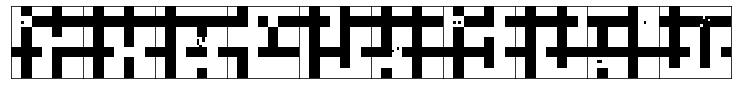

In [7]:
visual_samples_ebm(images_final)